### Visualizing Responses

In [9]:
import matplotlib.pyplot as plt
import numpy as np

X = np.load('X_data.npy', mmap_mode='r')
y = np.load('Y_data.npy', mmap_mode='r')



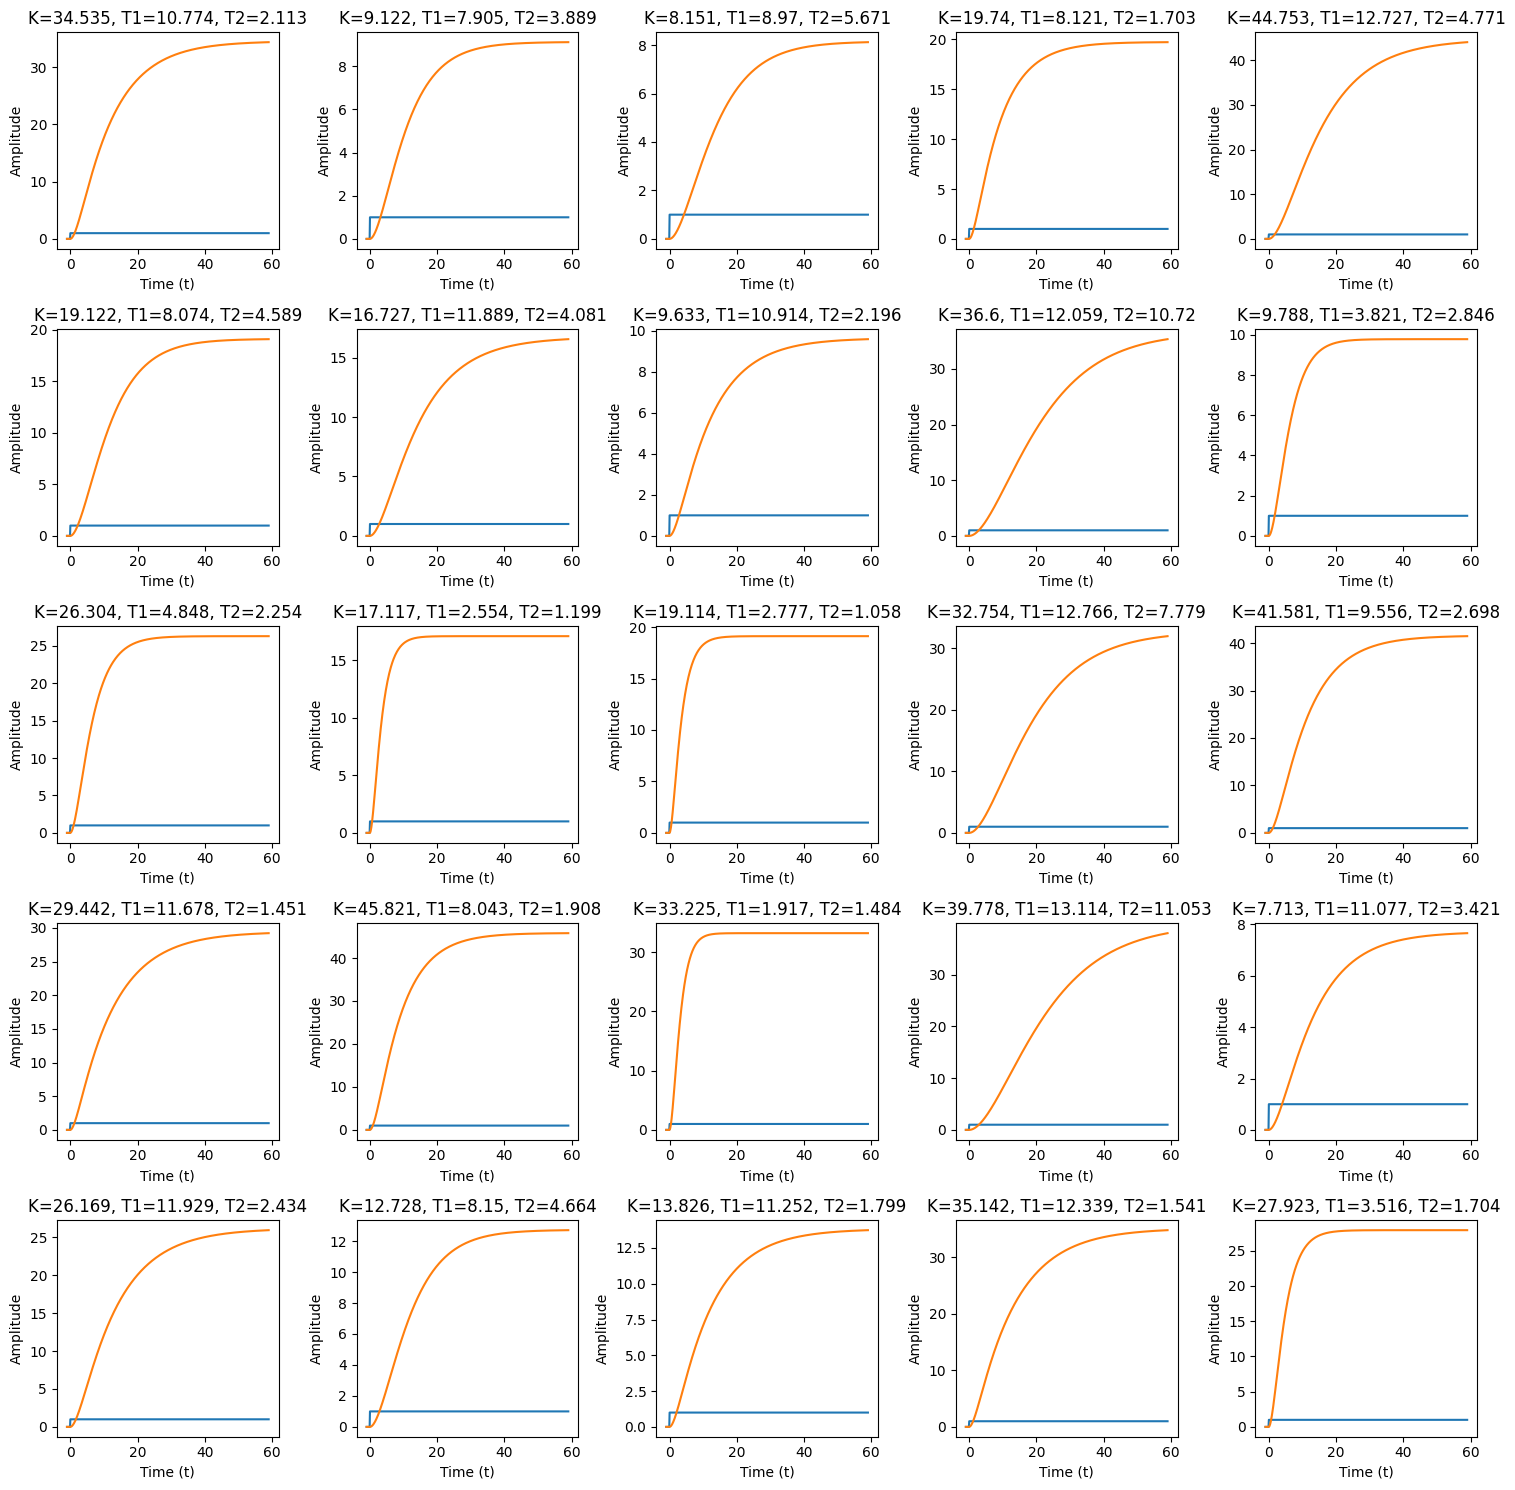

In [10]:
# ...existing code...
responses = X[0:25]
fig, axes = plt.subplots(nrows= 5, ncols=5, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
    t = responses[i][:, 2]
    x_e = responses[i][:, 0]
    x_a = responses[i][:, 1]
    K = y[i][0]
    T1 = y[i][1]
    T2 = y[i][2]
    ax.plot(t, x_e, label='x_e')
    ax.plot(t, x_a, label='x_a')
    ax.set_title(f'K={K}, T1={T1}, T2={T2}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Amplitude')

plt.tight_layout() # Adjust subplot params for a tight layout
plt.show() # Display the figure

### Parameters

In [11]:
import numpy as np
import matplotlib.pyplot as plt

y = np.asarray(y, dtype=float)  # ensure numeric array, shape (N,3)

labels = ['K', 'T1', 'T2']
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, ax in enumerate(axes):
    ax.hist(y[:, i], bins=30, color=f'C{i}', alpha=0.8)
    ax.set_title(f'Histogram of {labels[i]}')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'pt2/Y_data.npy'

### TRAINING MODEL

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if len(physical_devices) > 0:
    print(f"Device Name: {physical_devices[0].name}")
else:
    print("⚠️ No GPU found. Training will run on CPU.")

random_state = 42


In [ ]:
# 1. Define the Model Architecture
model = Sequential()

# Convolutional Layer: 32 filters, kernel size of 3
# input_shape ignores the batch size (1000), so it is (600, 3)
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(600, 3)))
# Pooling Layer: Downsample by taking the max value in a window of 2
model.add(MaxPooling1D(pool_size=2))
# Flatten Layer: Convert the 2D matrix to a 1D vector
model.add(Flatten())
# Hidden Dense Layer: Intermediate processing
model.add(Dense(64, activation='relu'))

# Output Layer: 3 neurons for the 3 regression targets
# We use 'relu' here to ensure predictions are always positive
model.add(Dense(3, activation='relu'))
# 2. Compile the Model
# Optimizer: Adam is a standard, efficient choice
# Loss: Mean Squared Error (MSE) for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

In [ ]:
model.summary()